# UNIFY DATA

## Restructure Data
### Existing Directory Structure

* OpenData
  * Captoren_2017
    * DataSet_**country**_EAD_Node-ID-**node_id**_2018.csv
    * DocInfo_**country**_EAD_Node-ID**node_id**_2018.pdf
    * locations.csv
  * Raptoren_2017
    * **country**
      * readme.txt
      * Raptor_**node_id**.csv

### New Directory Structure

* OpenData
  * 2018
    * **country**
      * [Raptor|Captor]_**node_id**.json    

### New Data Structure (JSON)

#### Example
{  
"id": "01",  
"fullid": "17001",  
"country": "Spain",   
"location": "Carmagnola (Piemonte)",   
"geo": [44.8469469, 7.7178740999999995],   
"data": [  
{"date": "Wednesday, 31 May 2017 11:00", "ozone": 32.0},  
{"date": "Wednesday, 31 May 2017 11:30", "ozone": 38.0},  
...  
]  
}  
  

## Settings

In [73]:
# set the year
year = 2017

## Process Captor Data

In [67]:
import glob
import os
import pandas as pd
import json
import re 
import csv
import io

#
# UNIFY CAPTORS
#
data_files = glob.glob('OpenData/Captoren_{}/DataSet*.csv'.format(year))

locs={}
with io.open('OpenData/Captoren_{}/locations.csv'.format(year), 'r') as ifile:
    reader = csv.reader(ifile, delimiter=',', quotechar='"')
    for row in reader:
        ids = row[0]
        locs[ids] = [row[1],row[2],row[3],row[4]]

for f in data_files:        
    jdata = {}
    country = f.split('_')[2]
    id_str = f.split('_')[4].split('-')[1][-2:]
    
    # read data file
    timings = pd.read_csv(f, sep=';')
    timings = timings[['Start_local','Ozone']]
    timings['Start_local'] = pd.to_datetime(timings['Start_local'], 
                                            format="%d/%m/%Y %H:%M").dt.strftime('%A, %d %B %Y %H:%M')
    
    # remove empty values
    timings = timings.dropna(axis=0, how='any')
    
    # rename col header
    timings.columns = ['date','ozone']
    
    location_dict = locs[str(int(id_str))]  #8 ??
    location = location_dict[1]
    
    # create json data dict
    jdata['id'] = id_str
    jdata['fullid'] = "170" + id_str
    jdata['country'] = country
    jdata['location'] = location
    jdata['geo'] = [float(location_dict[2]), float(location_dict[3])] #[ float(l[(l[0] == int(id_str))][3]),  float(l[(l[0] == int(id_str))][4]) ]
    jdata['data'] = timings.to_dict(orient = "records")
    
    # outfile
    dst = "OpenData/" + str(year) + "/" + country + "/Captor_" + id_str + ".json"
    print(dst)
    
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    
    # write json to file
    with io.open(dst, 'w', encoding='utf8') as ofile:
        json.dump(jdata, ofile, ensure_ascii=False)

        
print("done")

OpenData/2017/Spain/Captor_01.json
OpenData/2017/Spain/Captor_22.json
OpenData/2017/Spain/Captor_23.json
OpenData/2017/Spain/Captor_16.json
OpenData/2017/Spain/Captor_17.json
OpenData/2017/Italy/Captor_30.json
OpenData/2017/Italy/Captor_31.json
OpenData/2017/Spain/Captor_25.json
OpenData/2017/Spain/Captor_11.json
OpenData/2017/Spain/Captor_10.json
OpenData/2017/Spain/Captor_06.json
OpenData/2017/Spain/Captor_07.json
OpenData/2017/Spain/Captor_15.json
OpenData/2017/Spain/Captor_14.json
OpenData/2017/Italy/Captor_33.json
OpenData/2017/Spain/Captor_21.json
OpenData/2017/Spain/Captor_20.json
OpenData/2017/Spain/Captor_02.json
OpenData/2017/Spain/Captor_03.json
OpenData/2017/Italy/Captor_24.json
OpenData/2017/Spain/Captor_09.json
OpenData/2017/Spain/Captor_05.json
OpenData/2017/Spain/Captor_04.json
OpenData/2017/Italy/Captor_29.json
OpenData/2017/Italy/Captor_28.json
OpenData/2017/Spain/Captor_12.json
OpenData/2017/Spain/Captor_13.json
OpenData/2017/Italy/Captor_34.json
OpenData/2017/Italy/

## Process Raptor Data

In [68]:
import glob
import os
import pandas as pd
import json
import re 

#
# UNIFY RAPTORS
#
dirs = glob.glob('OpenData/Raptoren_{}/*'.format(year))

for d in dirs:
    # get all data-files + addon infos from readme.txt
    readme_file = d + '/readme.txt'
    readme = io.open(readme_file,'r')
    result = re.findall(
        r"""(?mx)           
        ^Caption:\ (.*)\n
        Full\ ID:\ (.*).*\n
        Locations:\ (.*).*\n
        Coordinate:\ (.*)$""",
        readme.read())

    for res in result:
        data_file = d + "/" + res[0] + ".csv"
        country = d.split('/')[-1:][0]
        id_str = res[0].split('_')[1]
        full_id = res[1]
        location = res[2]
        lat = float(res[3].split(',')[0].strip())
        lon = float(res[3].split(',')[1].strip())
        
        try:
            # read data file
            timings = pd.read_csv(data_file, sep=';')
            
            timings = timings[['date','Ozone concentration']]
            timings['date'] = pd.to_datetime(timings['date'], format="%Y-%m-%dT%H:%M:%S").dt.strftime('%A, %d %B %Y %H:%M')
            # remove empty values
            timings = timings.dropna(axis=0, how='any')
            # rename col header
            timings.columns = ['date','ozone']

            # create json data dict
            jdata = {}
            jdata['id'] = id_str
            jdata['fullid'] = full_id
            jdata['country'] = country
            jdata['location'] = location
            jdata['geo'] = [lat,lon]
            jdata['data'] = timings.to_dict(orient = "records")

            # write json to file
            dst = "OpenData/" + str(year) + "/" + country + "/Raptor_" + id_str + ".json"
            print(dst)

            os.makedirs(os.path.dirname(dst), exist_ok=True)

            with io.open(dst, 'w', encoding='utf8') as ofile:
                json.dump(jdata, ofile, ensure_ascii=False)
            
        except FileNotFoundError:
            print("No such file: {}".format(data_file))
        except:
            print("Unexpected error:", sys.exc_info()[0])
            raise

            
print("done")

OpenData/2017/Spain/Raptor_N70.json
OpenData/2017/Italy/Raptor_N69.json
OpenData/2017/Italy/Raptor_N202.json
OpenData/2017/Italy/Raptor_N204.json
OpenData/2017/Italy/Raptor_N206.json
OpenData/2017/Italy/Raptor_N208.json
OpenData/2017/Italy/Raptor_N210.json
OpenData/2017/Italy/Raptor_N212.json
OpenData/2017/Italy/Raptor_N214.json
OpenData/2017/Italy/Raptor_N216.json
OpenData/2017/Italy/Raptor_N218.json
OpenData/2017/Austria/Raptor_N72.json
OpenData/2017/Austria/Raptor_N73.json
OpenData/2017/Austria/Raptor_N90.json
OpenData/2017/Austria/Raptor_N302.json
OpenData/2017/Austria/Raptor_N304.json
OpenData/2017/Austria/Raptor_N306.json
OpenData/2017/Austria/Raptor_N308.json
OpenData/2017/Austria/Raptor_N310.json
OpenData/2017/Austria/Raptor_N314.json
OpenData/2017/Austria/Raptor_N318.json
done


# Example: Ozone-Value-Chart from JSON

Testing vega-chart

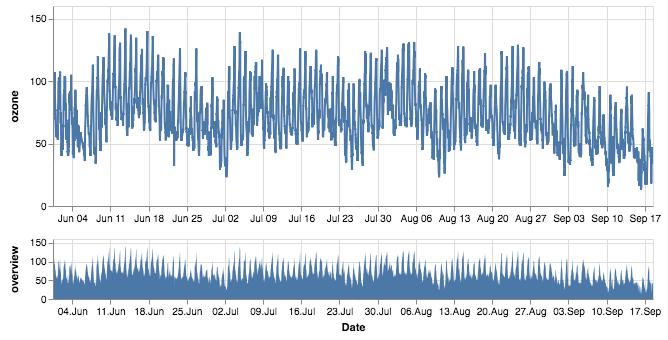

In [69]:
import json
from vega import VegaLite, Vega


file = io.open('OpenData/{}/Spain/Captor_01.json'.format(year),'r')
d = json.loads(file.read())

test = {}
test["date"] = {}
test["ozone"] = {}
for i,x in enumerate(d["data"]):
    test["date"][i] = x["date"]
    test["ozone"][i] = x["ozone"]
    
timings = pd.DataFrame.from_dict(test)
timings = timings[['date','ozone']]

v = VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v2.json",
    "description": "Ozone Chart",
    "vconcat": [{
        "width": 600,
        "mark": "line",
        "encoding": {
            "x": {
                "field": "date",
                "type": "temporal",
                "scale": {
                    "domain": {
                        "selection": "brush"
                    }
                },
                "axis": {
                    "title": ""
                }
            },
            "y": {
                "field": "ozone",
                "type": "quantitative"
            }
        }
    },
    {
        "width": 600,
        "height": 60,
        "mark": "area",
        "selection": {
            "brush": {
                "type": "interval",
                "encodings": ["x"]
            }
        },
        "encoding": {
            "x": {
                "field": "date",
                "type": "temporal",
                "axis": {
                    "format": "%d.%b",
                    "title": "Date"
                }
            },
            "y": {
                "field": "ozone",
                "type": "quantitative",
                "axis": {
                    "title":"overview",
                    "tickCount": 3
                }
            }
        }
    }
]}, [])

VegaLite(v.spec,timings)


# Generate Chart HTML Files for each json-data-file

In [70]:
# WORKING OUTPUT TO HMTL
from jinja2 import Template
template = Template(u"""
<!DOCTYPE html>
<html>
<head>
  <meta http-equiv="Content-Type" content="text/html; charset=utf-8" />
  <script src="https://cdn.jsdelivr.net/npm/vega@3"></script>
  <script src="https://cdn.jsdelivr.net/npm/vega-lite@2"></script>
  <script src="https://cdn.jsdelivr.net/npm/vega-embed@3"></script>
  <style>
  body { font-family:Futura,Verdana,sans-serif;}
  .info {
      font-style:italic;
      width: 100%;
      text-align: center;
  }
  </style>
</head>
<body>
  <h1>{{title}} {% if pdflink %}<a href="#">{{pdflink}}</a>{% endif %}</h1>
  <div id="vis"></div>
  <script type="text/javascript">
    var spec = {{specs}};
    var opt = {"renderer": "canvas", "actions": false};
    vegaEmbed("#vis", spec, opt);
  </script>
  <div class="info">
  Tip: By selecting a timespan in the overview you can zoom into the data.</div>
</body>
</html>
""")

# Define VEGA SPEC
v = VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v2.json",
    "description": "Ozone Chart",
    "vconcat": [{
        "width": 600,
        "mark": "line",
        "encoding": {
            "x": {
                "field": "date",
                "type": "temporal",
                "scale": {
                    "domain": {
                        "selection": "brush"
                    }
                },
                "axis": {
                    "title": ""
                }
            },
            "y": {
                "field": "ozone",
                "type": "quantitative"
            }
        }
    },
    {
        "width": 600,
        "height": 60,
        "mark": "area",
        "selection": {
            "brush": {
                "type": "interval",
                "encodings": ["x"]
            }
        },
        "encoding": {
            "x": {
                "field": "date",
                "type": "temporal",
                "axis": {
                    "format": "%d.%b",
                    "title": "Date"
                }
            },
            "y": {
                "field": "ozone",
                "type": "quantitative",
                "axis": {
                    "title":"overview",
                    "tickCount": 3
                }
            }
        }
    }
]}, [])


# create node.html for all nodes
json_files = glob.glob('OpenData/{}/*/*'.format(year))

for json_file in json_files:
    with io.open(json_file, 'r', encoding='utf8') as file:
        d = json.loads(file.read(), encoding='utf8')
        vis = VegaLite(v.spec, d["data"])
        html = template.render(specs=vis.spec, title=d["location"])
        ofile_name = 'results/' + str(year) + '/node_charts/' + d['fullid'] + '.html'
        os.makedirs(os.path.dirname(ofile_name), exist_ok=True)
        
        with io.open(ofile_name, 'w', encoding='utf8') as ofile:
            ofile.write(html)
        
print("done")

done


# Create GeoMapping (index.html)

In [71]:
import glob
import pandas as pd
import folium
from folium.plugins import MarkerCluster
import branca
import bs4

## MAP
json_files = glob.glob('OpenData/{}/*/*'.format(year))
geos = [] # list

for json_file in json_files:
    file = open(json_file,'r')
    d = json.loads(file.read())
    geos.append((d["geo"][0],d["geo"][1],d["fullid"]))
    
smap = folium.Map([44.7, 9], zoom_start=6)
mc = MarkerCluster()

for row in geos:
    chart_file = 'results/' + str(year) + '/node_charts/' + row[2] + '.html'
    with io.open(chart_file, 'r') as chart:
        html = chart.read()

    icon_str='cloud'
    color_str='cadetblue'
    
    if re.match('.*Raptor.*',row[2]):
        icon_str='cloud'
        color_str='purple'
    
    mc.add_child(
        folium.Marker(
            location=[row[0],row[1]],
            popup=folium.Popup(
                branca.element.IFrame(
                    html=html,
                    width=700, 
                    height=500
                ), 
                max_width=2650
            ), 
            icon=folium.Icon(icon=icon_str, color=color_str)))

smap.add_child(mc)
smap.save(os.path.join('results', str(year), 'index.html'))

print("done")

done


# Add some styling and info elements

In [72]:
with open("results/{}/index.html".format(str(year))) as inf:
    txt = inf.read()
    soup = bs4.BeautifulSoup(txt)

# add style
style_string = " .year { position: absolute; top: 8px; right: 16px; font-size: 2.5em;" \
    "font-weight: bold;color: #28536C; color: #113951;z-index:999;}"
soup.head.style.append(style_string)

# add year layer
year_layer = soup.new_tag("div")
year_layer['class'] = 'year'
year_layer.string=str(year)
soup.body.append(year_layer)

with open("results/{}/index.html".format(str(year)), "w") as outf:
    outf.write(str(soup))
